In [ ]:
import networkx as nx
print(nx.__version__)
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
%matplotlib inline

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255., X_test / 255.
plt.imshow(X_train[1298])

In [2]:
import numpy as np
from skimage import color, segmentation

NP_TORCH_FLOAT_DTYPE = np.float32
NP_TORCH_LONG_DTYPE = np.int64

NUM_FEATURES = 5
NUM_CLASSES = 10

def _preprocess(image):
    if len(image.shape) == 2 or image.shape[2] == 1:
        return color.gray2rgb(
            np.reshape(image, (image.shape[0], image.shape[1])))
    else:
        return image

def get_graph_from_image(image, desired_nodes=75):
    # load the image and convert it to a floating point data type
    image = _preprocess(image)
    segments = segmentation.slic(image, desired_nodes, slic_zero = True)
    asegments = np.array(segments)

    num_nodes = np.max(asegments)
    nodes = {
        node: {
            "rgb_list": [],
            "pos_list": []
        } for node in range(num_nodes+1)
    }

    height = image.shape[0]
    width = image.shape[1]
    for y in range(height):
        for x in range(width):
            node = asegments[y,x]
            rgb = image[y,x,:]
            pos = np.array([float(x)/width,float(y)/height])
            nodes[node]["rgb_list"].append(rgb)
            nodes[node]["pos_list"].append(pos)

    G = nx.Graph()
    for node in nodes:
        try:
            nodes[node]["rgb_list"] = np.stack(nodes[node]["rgb_list"])
            nodes[node]["pos_list"] = np.stack(nodes[node]["pos_list"])
            rgb_mean = np.mean(nodes[node]["rgb_list"], axis=0)
            pos_mean = np.mean(nodes[node]["pos_list"], axis=0)
            features = np.concatenate(
                [
                    np.reshape(rgb_mean, -1),
                    np.reshape(pos_mean, -1),
                ]
            )
            G.add_node(node, features = list(features))
        except:
            pass


    # From https://stackoverflow.com/questions/26237580/skimage-slic-getting-neighbouring-segments
    segments_ids = np.unique(segments)

    # centers
    centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])

    vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
    vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
    bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

    # Adjacency loops
    for i in range(bneighbors.shape[1]):
        if bneighbors[0,i] != bneighbors[1,i]:
            G.add_edge(bneighbors[0,i],bneighbors[1,i])

    # Self loops
    for node in nodes:
        G.add_edge(node,node)

    n = G.number_of_nodes()
    m = G.number_of_edges()
    h = np.zeros([n,NUM_FEATURES]).astype(NP_TORCH_FLOAT_DTYPE)
    edges = np.zeros([2*m,2]).astype(NP_TORCH_LONG_DTYPE)
    # print(G.edges())
    for e,(s,t) in enumerate(G.edges()):
        edges[e,0] = s
        edges[e,1] = t

        edges[m+e,0] = t
        edges[m+e,1] = s

    for i in G.nodes():
        try:
            h[i,:] = list(G.nodes(data='features'))[i][1]['features'][:NUM_FEATURES]
        except:
            pass
    #end for
    del G
    return h[:, 0:], edges

In [3]:
h, e = get_graph_from_image(X_train[1298])
h

array([[0.        , 0.        , 0.        , 0.03571429, 0.03571429],
       [0.        , 0.        , 0.        , 0.14285715, 0.03571429],
       [0.        , 0.        , 0.        , 0.25      , 0.03571429],
       [0.        , 0.        , 0.        , 0.35714287, 0.03571429],
       [0.        , 0.        , 0.        , 0.4642857 , 0.03571429],
       [0.        , 0.        , 0.        , 0.5714286 , 0.03571429],
       [0.        , 0.        , 0.        , 0.6785714 , 0.03571429],
       [0.        , 0.        , 0.        , 0.78571427, 0.03571429],
       [0.        , 0.        , 0.        , 0.91071427, 0.03571429],
       [0.        , 0.        , 0.        , 0.03571429, 0.14285715],
       [0.        , 0.        , 0.        , 0.14285715, 0.14285715],
       [0.        , 0.        , 0.        , 0.25      , 0.14285715],
       [0.        , 0.        , 0.        , 0.35714287, 0.14285715],
       [0.00490196, 0.00490196, 0.00490196, 0.45982143, 0.13839285],
       [0.18518518, 0.18518518, 0.

In [5]:
import torch
print(len(h))
print(h.shape)
print(len(e))
print(e.shape)
print(e.reshape(2, -1).shape)
print(torch.tensor(e).t().to(torch.long).view(2, -1).shape)
print(torch.tensor(h, dtype=torch.float).shape)

82
(82, 5)
500
(500, 2)
(2, 500)
torch.Size([2, 500])
torch.Size([82, 5])


In [6]:
from matplotlib.lines import Line2D

def plot_graph_from_image(image,desired_nodes=75,save_in=None):
    image = _preprocess(image)
    segments = segmentation.slic(image, slic_zero = True, compactness=10, max_num_iter=10, sigma=0)

    # show the output of SLIC
    fig = plt.figure("Superpixels")
    ax = fig.add_subplot(1, 1, 1)
    #ax.imshow(mark_boundaries(image, segments), cmap="gray")
    ax.imshow(image)#, cmap="gray")
    plt.axis("off")

    asegments = np.array(segments)

    # From https://stackoverflow.com/questions/26237580/skimage-slic-getting-neighbouring-segments

    segments_ids = np.unique(segments)

    # centers
    centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])

    vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
    vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
    bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

    plt.scatter(centers[:,1],centers[:,0], c='y')

    for i in range(bneighbors.shape[1]):
        try:
            y0,x0 = centers[bneighbors[0,i]]
            y1,x1 = centers[bneighbors[1,i]]

            l = Line2D([x0,x1],[y0,y1], c="w", alpha=0.5)
            ax.add_line(l)
        except:
            pass

    # show the plots
    if save_in is None:
        plt.show()
    else:
        plt.savefig(save_in,bbox_inches="tight")
    plt.close()

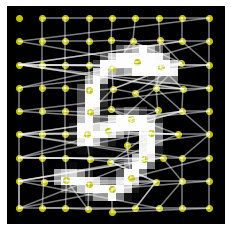

In [7]:
plot_graph_from_image(X_train[1298])

In [10]:
import os
import torch
from tqdm.auto import tqdm
from torch_geometric.data import Data, Dataset

class ImageSuperpixelsDataset(Dataset):
    def __init__(self, root, test=False, transform=None, pre_transform=None):
        self.test = test
        super(ImageSuperpixelsDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return 'ImagesSuperpixels.pt'

    @property
    def processed_file_names(self):
        if self.test:
            return [f'data_test_{i}.pt' for i in range(len(X_test))]
        else:
            return [f'data_{i}.pt' for i in range(len(X_train))]

    def download(self):
        pass

    def process(self):
        if self.test:
            for i, j in tqdm(enumerate(X_test), total=len(X_test)):
                h, edge_index = get_graph_from_image(X_test[i])
                # Create Data Object
                data = Data(x=torch.tensor(h, dtype=torch.float),
                            edge_index=torch.tensor(edge_index).t().to(torch.long).view(2, -1),
                            y=torch.tensor([y_test[i]], dtype=torch.int64))

                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'data_test_{i}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'data_{i}.pt'))
        else:
            for i, j in tqdm(enumerate(X_train), total=len(X_train)):
                h, edge_index = get_graph_from_image(X_train[i])

                # Create Data Object
                data = Data(x=torch.tensor(h, dtype=torch.float),
                            edge_index=torch.tensor(edge_index).t().to(torch.long).view(2, -1),
                            y=torch.tensor([y_train[i]], dtype=torch.int64))

                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'data_test_{i}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'data_{i}.pt'))

    def len(self):
        if self.test:
            return len(X_test)
        else:
            return len(X_train)

    def get(self, idx):
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [11]:
train_dataset = ImageSuperpixelsDataset(root='data/')

Processing...


  0%|          | 0/60000 [00:00<?, ?it/s]

Done!


In [12]:
train_dataset[59708]

Data(x=[82, 5], edge_index=[2, 492], y=[1])

In [13]:
test_dataset = ImageSuperpixelsDataset(root='data/', test=True)

Processing...


  0%|          | 0/10000 [00:00<?, ?it/s]

Done!


In [14]:
test_dataset[1]

Data(x=[80, 5], edge_index=[2, 488], y=[1])

In [15]:
train_dataset[0].x

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5714e-02, 3.5714e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4286e-01, 3.5714e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5000e-01, 3.5714e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5714e-01, 3.5714e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.6429e-01, 3.5714e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7143e-01, 3.5714e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 6.7857e-01, 3.5714e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.8571e-01, 3.5714e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 9.1071e-01, 3.5714e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5714e-02, 1.4286e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4286e-01, 1.4286e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5000e-01, 1.4286e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5714e-01, 1.4286e-01],
        [1.6993e-02, 1.6993e-02, 1.6993e-02, 4.6429e-01, 1.4286e-01],
        [1.0084e-02,

In [23]:
train_dataset[0].edge_index.t()

tensor([[ 1,  2],
        [ 1, 10],
        [ 1,  1],
        [ 2,  3],
        [ 2, 11],
        [ 2,  2],
        [ 3,  4],
        [ 3, 12],
        [ 3,  3],
        [ 4,  5],
        [ 4, 13],
        [ 4,  4],
        [ 5,  6],
        [ 5, 14],
        [ 5,  5],
        [ 6,  7],
        [ 6, 15],
        [ 6,  6],
        [ 7,  8],
        [ 7, 16],
        [ 7,  7],
        [ 8,  9],
        [ 8, 17],
        [ 8,  8],
        [ 9, 18],
        [ 9,  9],
        [10, 11],
        [10, 20],
        [10, 10],
        [11, 12],
        [11, 21],
        [11, 11],
        [12, 13],
        [12, 22],
        [12, 12],
        [13, 14],
        [13, 22],
        [13, 23],
        [13, 13],
        [14, 15],
        [14, 23],
        [14, 24],
        [14, 14],
        [15, 16],
        [15, 19],
        [15, 25],
        [15, 15],
        [16, 17],
        [16, 19],
        [16, 16],
        [17, 18],
        [17, 19],
        [17, 26],
        [17, 17],
        [18, 27],
        [1

In [17]:
# from torch_geometric.utils import to_networkx
# G = to_networkx(train_dataset[0], to_undirected=True)
# plt.figure(1, figsize=(8, 8))
# nx.draw(G, cmap=plt.get_cmap('Set3'), node_size=70)
# plt.show()

In [18]:
from torch_geometric.data import DataLoader
NUM_GRAPHS_PER_BATCH = 32
train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

D:\Anaconda\envs\graph-nx\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [19]:
next(iter(train_loader))

DataBatch(x=[2584, 5], edge_index=[2, 15674], y=[32], batch=[2584], ptr=[33])

In [20]:
next(iter(test_loader))

DataBatch(x=[2578, 5], edge_index=[2, 15596], y=[32], batch=[2578], ptr=[33])

In [21]:
for step, data in enumerate(train_loader):
    if (step + 1) == 6:
        break
    print(f'Step {step + 1}:')
    print('=================')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print(data.x.shape)
    print(data.y.shape)

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[2591, 5], edge_index=[2, 15586], y=[32], batch=[2591], ptr=[33])
torch.Size([2591, 5])
torch.Size([32])
Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[2577, 5], edge_index=[2, 15484], y=[32], batch=[2577], ptr=[33])
torch.Size([2577, 5])
torch.Size([32])
Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[2580, 5], edge_index=[2, 15628], y=[32], batch=[2580], ptr=[33])
torch.Size([2580, 5])
torch.Size([32])
Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[2585, 5], edge_index=[2, 15572], y=[32], batch=[2585], ptr=[33])
torch.Size([2585, 5])
torch.Size([32])
Step 5:
Number of graphs in the current batch: 32
DataBatch(x=[2580, 5], edge_index=[2, 15512], y=[32], batch=[2580], ptr=[33])
torch.Size([2580, 5])
torch.Size([32])
Step 6:
Number of graphs in the current batch: 32
DataBatch(x=[2582, 5], edge_index=[2, 15660], y=[32], batch=[2582], ptr=[33])
torch.Size([2582, 5])
torch.Size([32]

In [24]:
train_dataset.num_features

5

In [25]:
from torch.nn import Linear, Flatten
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAT
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(train_dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.flatten = Flatten()
        self.lin = Linear(hidden_channels, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.flatten(x)
        x = F.dropout(x, p=0.5, training=self.training)

        return F.log_softmax(self.lin(x), dim=1)

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(5, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Linear(in_features=64, out_features=10, bias=True)
)


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [27]:
model = GCN(hidden_channels=64)
model.to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:
        out = model(data.x.pin_memory().to(device), data.edge_index.pin_memory().to(device), data.batch.pin_memory().to(device))
        loss = criterion(out, data.y.pin_memory().to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x.pin_memory().to(device), data.edge_index.pin_memory().to(device), data.batch.pin_memory().to(device))
        pred = out.argmax(dim=1)
        correct += int((pred == data.y.pin_memory().to(device)).sum())
    return correct / len(loader.dataset)

for epoch in range(0, 200):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

GCN(
  (conv1): GCNConv(5, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Linear(in_features=64, out_features=10, bias=True)
)
Epoch: 000, Train Acc: 0.2967, Test Acc: 0.2945
Epoch: 001, Train Acc: 0.3333, Test Acc: 0.3348
Epoch: 002, Train Acc: 0.3561, Test Acc: 0.3638
Epoch: 003, Train Acc: 0.5194, Test Acc: 0.5172
Epoch: 004, Train Acc: 0.5563, Test Acc: 0.5630
Epoch: 005, Train Acc: 0.5834, Test Acc: 0.5903
Epoch: 006, Train Acc: 0.6071, Test Acc: 0.6150
Epoch: 007, Train Acc: 0.6104, Test Acc: 0.6171
Epoch: 008, Train Acc: 0.6094, Test Acc: 0.6140
Epoch: 009, Train Acc: 0.5905, Test Acc: 0.5954
Epoch: 010, Train Acc: 0.5736, Test Acc: 0.5773
Epoch: 011, Train Acc: 0.6179, Test Acc: 0.6262
Epoch: 012, Train Acc: 0.6186, Test Acc: 0.6205
Epoch: 013, Train Acc: 0.6181, Test Acc: 0.6235
Epoch: 014, Train Acc: 0.6344, Test Acc: 0.6416
Epoch: 015, Train Acc: 0.6330, Test Acc: 0.6402
Epoch: 016, Train Acc: 0.6318, Test Acc

KeyboardInterrupt: 